In [1]:

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import itertools
import datetime
import time
import warnings
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RepeatedKFold
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor
import optuna
import seaborn as sns
random_state =42

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)



In [2]:
sub_df=pd.read_csv('../input/gdz22-datathon-case-2-v3/2022gdz22-datathon-case-2/submission.csv')
test_df=pd.read_csv('../input/gdz22-datathon-case-2-v3/2022gdz22-datathon-case-2/test.csv')
train_df=pd.read_csv('../input/gdz22-datathon-case-2-v3/2022gdz22-datathon-case-2/train.csv')

train_df['data']='train'
test_df['data']='test'
df=pd.concat([train_df,test_df])
######################################################################################################
#df["CALENDAR_DATE"] = df["BAŞLAMA_TARİHİ_VE_ZAMANI"].apply(lambda x:x[:10]).astype(str)
#df["CALENDAR_DATE"] = df["CALENDAR_DATE"].apply(fun)
#calendar = pd.read_csv("../input/turkish-calendar/Turkish calendar.csv",sep=";")
#calendar["CALENDAR_DATE"] = pd.to_datetime(calendar["CALENDAR_DATE"])
#cl =calendar.query("CALENDAR_DATE >='2021-05-01'&CALENDAR_DATE <='2022-08-21'").reset_index(drop=True)
#cl["CALENDAR_DATE"]=cl["CALENDAR_DATE"].astype(str)
#cl.loc[cl["NATIONAL_DAY_FLAG_SK"] == 200,"NATIONAL_DAY_FLAG_SK"] = 0
#cl.loc[cl["RELIGIOUS_DAY_FLAG_SK"] == 100,"RELIGIOUS_DAY_FLAG_SK"] = 0
#cl["holiday"] = cl["RELIGIOUS_DAY_FLAG_SK"]+cl["NATIONAL_DAY_FLAG_SK"]
#cl.loc[(cl["holiday"] != 0),"holiday"] = 1
#df['OutageID_cat'] = pd.Categorical(
#    df['OutageID'], 
#    categories=df['OutageID'].values, 
#    ordered=True
#)
#df = df.merge(cl.loc[:,["CALENDAR_DATE","holiday"]],on="CALENDAR_DATE")
#df = df.sort_values("OutageID_cat")
#df.drop(["CALENDAR_DATE","OutageID_cat","holiday"],axis=1,inplace=True)
######################################################################################################
nfs = pd.read_csv("../input/trkiye-ile-nfusu-ve-art-hz/turkiye_ilce_nufusu.csv")
nfs.columns = ["İLÇE","Nüfus","İlveilçemerkezleri","Beldeveköyler","Yıllıknüfusartışhızı"]
nfs["İLÇE"] = nfs["İLÇE"].apply(lambda x:x.upper()).replace({"SEFERIHISAR":"SEFERİHİSAR","DIKILI":"DİKİLİ","TIRE":"TİRE","AKHISAR":"AKHİSAR","KIRAZ":"KİRAZ","SALIHLI":"SALİHLİ","ALIAĞA":"ALİAĞA","ÖDEMIŞ":"ÖDEMİŞ","ÇIĞLI":"ÇİĞLİ","GAZIEMIR":"GAZİEMİR","DEMIRCI":"DEMİRCİ","ALAŞEHIR":"ALAŞEHİR","SELENDI":"SELENDİ","AHMETLI":"AHMETLİ"})
nfs["Nüfus"]= nfs["Nüfus"].apply(lambda x:x.replace(" ", "")).astype(int)
deneme2=pd.read_csv("../input/izmirmanisanufsrakm/deneme2.csv")
#deneme2["Nufus"]=deneme2["Nufus"].apply(lambda x:x.replace(",","")).astype(float)
deneme2["genislik"]=deneme2["genislik"].apply(lambda x:x.replace(",","")).astype(float)
#deneme2["oran"] = (nfs["Nüfus"])/(deneme2["genislik"]*100)
df = df.merge(deneme2.loc[:,["genislik","İLÇE"]],on="İLÇE",how="left")
nfs.drop([114,879],inplace=True)
######################################################################################################
df = df.merge(nfs.loc[:,["İLÇE","Nüfus"]],how="left")#
df["oran"] = df["Nüfus"]/(df["genislik"]*100)
df.drop(["Nüfus","genislik"],axis=1,inplace=True)
######################################################################################################
#dfinx = df.copy().index
#df["tarih"] = df["BAŞLAMA_TARİHİ_VE_ZAMANI"].apply(lambda x:x[:10])
#df = df.merge(temp,on=["tarih","İLÇE"])
#df.index = dfinx
#####################################################################################################
# print(df.shape)
# df["date_time"] = pd.to_datetime(df["BAŞLAMA_TARİHİ_VE_ZAMANI"].apply(lambda x:x[:-6]),format="%d.%m.%Y %H").astype("str")
# df =df.merge(weather.loc[:,["İLÇE","date_time","FeelsLikeC"]],on=["İLÇE","date_time"],how="left")
# df.drop(["date_time"],axis=1,inplace=True)
# print(df.shape)
######################################################################################################
df["holiday"] = 0
df["del_tarih"] = df["BAŞLAMA_TARİHİ_VE_ZAMANI"].apply(lambda x:x[:10])
for i in ['01.01.2021', '23.04.2021', '01.05.2021', '12.05.2021',
       '13.05.2021', '14.05.2021', '15.05.2021', '19.05.2021',
       '15.07.2021', '19.07.2021', '20.07.2021', '21.07.2021',
       '22.07.2021', '23.07.2021', '30.08.2021', '29.10.2021','01.01.2022', '23.04.2022', '01.05.2022', '02.05.2022',
       '03.05.2022', '04.05.2022', '19.05.2022', '08.07.2022',
       '09.07.2022', '10.07.2022', '11.07.2022', '12.07.2022',
       '13.07.2022', '14.07.2022', '15.07.2022', '30.08.2022',
       '28.10.2022', '29.10.2022']:
    df.loc[df["del_tarih"]==i,"holiday"]= 1
df.drop("del_tarih",axis=1,inplace=True)

df.BAŞLAMA_TARİHİ_VE_ZAMANI=pd.to_datetime(df.BAŞLAMA_TARİHİ_VE_ZAMANI,format="%d.%m.%Y %H:%M:%S")
df.SONA_ERME_TARİHİ_VE_ZAMANI=pd.to_datetime(df.SONA_ERME_TARİHİ_VE_ZAMANI,format="%d.%m.%Y %H:%M:%S")

df['baslangic_month']=df.BAŞLAMA_TARİHİ_VE_ZAMANI.dt.month
df['sona_erme_month']=df.SONA_ERME_TARİHİ_VE_ZAMANI.dt.month

df['baslangic_quarter']=df.BAŞLAMA_TARİHİ_VE_ZAMANI.dt.quarter
df['sona_erme_quarter']=df.SONA_ERME_TARİHİ_VE_ZAMANI.dt.quarter

df['baslangic_day']=df.BAŞLAMA_TARİHİ_VE_ZAMANI.dt.day
df['sona_erme_day']=df.SONA_ERME_TARİHİ_VE_ZAMANI.dt.day

df['baş_hour']=df.BAŞLAMA_TARİHİ_VE_ZAMANI.dt.hour
df['son_hour']=df.SONA_ERME_TARİHİ_VE_ZAMANI.dt.hour

df['baslangic_dayofweek']=df.BAŞLAMA_TARİHİ_VE_ZAMANI.dt.dayofweek
df['sona_erme_dayofweek']=df.SONA_ERME_TARİHİ_VE_ZAMANI.dt.dayofweek

df['year']=df.BAŞLAMA_TARİHİ_VE_ZAMANI.dt.year


In [3]:
assert df.shape[0] == 122143
assert df["OutageID"].value_counts().shape[0] == 122143
df.shape

(122143, 43)

In [4]:
# df["FeelsLikeC"] = np.sin((df["FeelsLikeC"]/8)+9.8)*20

In [5]:
def funk(x):
    if(x<=0.20):
        return "kısa"
    if(x>0.20):
        return "uzun"
    else:
        return "normal"
    df["SÜREYE_GÖRE"] = df["KESİNTİ_SÜRESİ"].apply(funk)

df["SÜREYE_GÖRE"] = df["KESİNTİ_SÜRESİ"].apply(funk)

In [6]:
label = "cagri_count"
except_cols = ["KESİNTİ_NO","KOD_NO", "ŞEBEKE_UNSURU_KODU",'SONA_ERME_TARİHİ_VE_ZAMANI','OutageID','BİLDİRİME_GÖRE','data','KADEME']
caterogical_cols = [
            "holiday",
            "İL",
            "İLÇE",
            "SÜREYE_GÖRE",
            "ŞEBEKE_UNSURU",
            "KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA",
            "KAYNAĞA_GÖRE",
            "SEBEBE_GÖRE",
            'baslangic_month',
            'sona_erme_month',
            'baslangic_quarter',
            'sona_erme_quarter',
            'baslangic_day',
            'sona_erme_day',
            'baslangic_dayofweek',
            'sona_erme_dayofweek',
            "baş_hour",
            "son_hour",
            "year"
           ]

X = df[df.data=='train'].drop(labels = except_cols + [label], axis=1)
y = df[df.data=='train'][label]

to_sub = df[df.data=='test'].drop(labels = except_cols+ [label], axis=1)

for caterogical_col in caterogical_cols:
    X[caterogical_cols] = X[caterogical_cols].astype(str).astype("category")
    to_sub[caterogical_cols] = to_sub[caterogical_cols].astype(str).astype("category")

In [7]:
X.loc[X["KESİNTİ_SÜRESİ"] < -2,["KESİNTİ_SÜRESİ"]] = 0
X.loc[X["KESİNTİ_SÜRESİ"] < 0,["KESİNTİ_SÜRESİ"]]= X.loc[X["KESİNTİ_SÜRESİ"] < 0,["KESİNTİ_SÜRESİ"]].apply(np.abs)
X.loc[X["TOPLAM_KENTSEL_OG"]<0,["TOPLAM_KENTSEL_OG","TOPLAM_KENTSEL_AG"]]=X.loc[X["TOPLAM_KENTSEL_OG"]<0,["TOPLAM_KENTSEL_OG","TOPLAM_KENTSEL_AG"]].apply(np.abs)
X.describe()

,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,TOPLAM_KENTALTI_AG,TOPLAM_KIRSAL_OG,TOPLAM_KIRSAL_AG,oran
count,105392.000000,105392.000000,105392.000000,105392.000000,105392.000000,105392.000000,105392.000000,105392.000000,105392.000000,105392.000000,105392.000000,105392.000000,105392.000000,105392.000000
mean,2.373879,7.799368,359.279860,1.234259,59.354069,2.370730,62.735701,7.551997,302.224957,0.966313,41.291327,1.768830,45.475548,12.667224
std,2.613654,36.745282,1690.032278,12.502370,584.891795,16.186787,382.329902,56.436233,1468.917225,18.799623,515.045242,20.171476,365.234550,29.960997
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023190
25%,0.931667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000564
50%,1.727222,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.098333,0.000000,0.000000,0.000000,0.000000,1.340373
75%,3.050278,0.000000,87.000000,0.000000,0.000000,0.000000,0.000000,0.000000,117.695000,0.000000,0.000000,0.000000,0.000000,3.464070
max,289.323333,1160.000000,70961.000000,735.000000,44781.000000,482.000000,11683.000000,6042.792222,129419.169441,3849.358333,74001.949997,2090.577778,31752.000000,140.227083


In [8]:
# def bisey(df):
#     df2 = df.copy()
#     X = df.copy()
#     X = X.sort_values(by="BAŞLAMA_TARİHİ_VE_ZAMANI")
#     X["cumcount"] = X.groupby("ŞEBEKE_UNSURU_KODU")["KESİNTİ_SÜRESİ"].transform("cumcount")
#     df2 = df2.merge(X.loc[:,["cumcount","OutageID"]],on="OutageID")
#     df2.drop(["ŞEBEKE_UNSURU_KODU","OutageID"],axis=1,inplace=True)
#     return df2
# X = bisey(X)
# to_sub = bisey(to_sub)


In [9]:
def kırsal_kent_kenta(df):
    X =df.copy()
    X["il_?"] = (X["KENTSEL_OG"]+X["KENTSEL_AG"]).astype(str)+"-"+(X["KENTALTI_OG"]+X["KENTALTI_AG"]).astype(str)+"-"+(X["KIRSAL_OG"]+X["KIRSAL_AG"]).astype(str)
    X["il_?"] = X["il_?"].apply(kentmaker)
    X["il_?"] = X["il_?"]+X["İL"].astype("str")
    X["il_?"] = X["il_?"].astype("category")
    return X
def kentmaker(x):
    x = x.split("-")
    
    x[0] = int(x[0])
    x[1] = int(x[1])
    x[2] = int(x[2])
    if x[0]>=x[1]:
        if x[0]>=x[2]:
            return"kent"
        if x[0]<x[2]:
            return"kırsal" 
    if x[1]>x[0]:
        if x[1]>x[2]:
            return"kentalt"
        if x[2]>=x[1]:
            return"kırsal"   
######################################################################################################    
X = kırsal_kent_kenta(X)
to_sub = kırsal_kent_kenta(to_sub)
caterogical_cols.append("il_?")

In [10]:
def vakit_hafta_mevsim(y):
    x = str(y)
    m = int(x[5:7])
    h = int(x[11:13])
    if m in [1,2,12,3]:#kış
        if y.dayofweek in[5,6]:#haftasonu
            if h in [0,1,2,3,4,5]:
                return "gece-hftsonu-kış"
            elif h in [6,7,8,9,10,11,12]:
                return "sabah-hftsonu-kış"
            elif h in [13,14,15,16,17,18]:
                return "öglen-hftsonu-kış"
            else:
                return "aksam-hftsonu-kış"
        else:
            if h in [0,1,2,3,4,5]:
                return "gece-hftiçi-kış"
            elif h in [6,7,8,9,10,11,12]:
                return "sabah-hftiçi-kış"
            elif h in [13,14,15,16,17,18]:
                return "öglen-hftiçi-kış"
            else:
                return "aksam-hftiçi-kış"                    
    elif m in [7,8,9]:#yaz
        if y.dayofweek in[5,6]:#haftasonu
            if h in [0,1,2,3,4,5]:
                return "gece-hftsonu-yaz"
            elif h in [6,7,8,9,10,11,12]:
                return "sabah-hftsonu-yaz"
            elif h in [13,14,15,16,17,18]:
                return "öglen-hftsonu-yaz"
            else:
                return "aksam-hftsonu-yaz"
        else:
            if h in [0,1,2,3,4,5]:
                return "gece-hftiçi-yaz"
            elif h in [6,7,8,9,10,11,12]:
                return "sabah-hftiçi-yaz"
            elif h in [13,14,15,16,17,18]:
                return "öglen-hftiçi-yaz"
            else:
                return "aksam-hftiçi-yaz"
    elif m in [4,5,6]:#yazlık
        if y.dayofweek in[5,6]:#haftasonu
            if h in [0,1,2,3,4,5]:
                return "gece-hftsonu-yazlık"
            elif h in [6,7,8,9,10,11,12]:
                return "sabah-hftsonu-yazlık"
            elif h in [13,14,15,16,17,18]:
                return "öglen-hftsonu-yazlık"
            else:
                return "aksam-hftsonu-yazlık"
        else:
            if h in [0,1,2,3,4,5]:
                return "gece-hftiçi-yazlık"
            elif h in [6,7,8,9,10,11,12]:
                return "sabah-hftiçi-yazlık"
            elif h in [13,14,15,16,17,18]:
                return "öglen-hftiçi-yazlık"
            else:
                return "aksam-hftiçi-yazlık"                    
    elif m in [10,11]:#okul
        if y.dayofweek in[5,6]:#haftasonu
            if h in [0,1,2,3,4,5]:
                return "gece-hftsonu-okul"
            elif h in [6,7,8,9,10,11,12]:
                return "sabah-hftsonu-okul"
            elif h in [13,14,15,16,17,18]:
                return "öglen-hftsonu-okul"
            else:
                return "aksam-hftsonu-okul"
        else:
            if h in [0,1,2,3,4,5]:
                return "gece-hftiçi-okul"
            elif h in [6,7,8,9,10,11,12]:
                return "sabah-hftiçi-okul"
            elif h in [13,14,15,16,17,18]:
                return "öglen-hftiçi-okul"
            else:
                return "aksam-hftiçi-okul"  
# ######################################################################################################
X["BAŞLAMA_TARİHİ_VE_ZAMANI"] = X["BAŞLAMA_TARİHİ_VE_ZAMANI"].apply(vakit_hafta_mevsim).astype("category")
to_sub["BAŞLAMA_TARİHİ_VE_ZAMANI"] = to_sub["BAŞLAMA_TARİHİ_VE_ZAMANI"].apply(vakit_hafta_mevsim).astype("category")
caterogical_cols.append("BAŞLAMA_TARİHİ_VE_ZAMANI")


In [11]:
def tplm_il_sebeb_süre(df):
    train = df.copy()
    train["new"]= train["SEBEBE_GÖRE"].astype(str)+train["İL"].astype(str)+train["SÜREYE_GÖRE"].astype(str)
    train["new"] = train["new"].astype("category")
    return train
######################################################################################################
X = tplm_il_sebeb_süre(X)
to_sub = tplm_il_sebeb_süre(to_sub)
caterogical_cols.append("new")

In [12]:
def en_son_skew(dfs):
    df = dfs.copy()
    col = ['KENTSEL_OG', 'KENTSEL_AG', 'KENTALTI_OG', 'KENTALTI_AG', 'KIRSAL_OG',
       'KIRSAL_AG', 'TOPLAM_KENTALTI_OG', 'TOPLAM_KENTALTI_AG',
       'TOPLAM_KIRSAL_OG', 'TOPLAM_KIRSAL_AG']
    for i in col:
        df[i] = np.log1p(df[i])
    return df
######################################################################################################
X = en_son_skew(X)
to_sub = en_son_skew(to_sub)

In [13]:
def outlier_thresholds(dataframes, col_name, q1=0.01, q3=0.99):
    dataframe = dataframes.copy()
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def replace_with_thresholds(dataframes, variable, q1=0.01, q3=0.99):
    dataframe = dataframes.copy()

    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    return dataframe
######################################################################################################
for i in ["KESİNTİ_SÜRESİ"]: 
    X[i] = replace_with_thresholds(X,i, q1=0.01, q3=0.99)[i]
    to_sub[i] = replace_with_thresholds(to_sub,i, q1=0.01, q3=0.99)[i]


In [14]:
def tplm_hat_süre(df):
    X = df.copy()
    X["etkilenen toplam hat"] = X["KENTSEL_AG"]+X["KENTALTI_AG"]+X["KIRSAL_AG"]+X["KENTSEL_OG"]+X["KENTALTI_OG"]+X["KIRSAL_OG"]
    X["etkilenen hatların toplam süresi"] = X["TOPLAM_KENTSEL_OG"]+X["TOPLAM_KENTSEL_AG"]+X["TOPLAM_KENTALTI_OG"]+X["TOPLAM_KENTALTI_AG"]+X["TOPLAM_KIRSAL_OG"]+X["TOPLAM_KIRSAL_AG"]
    X["oran"] = X["oran"]*X["etkilenen toplam hat"]
    return X
######################################################################################################    
X = tplm_hat_süre(X)
to_sub = tplm_hat_süre(to_sub)

In [15]:
# assert False ,"k"

In [16]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=7 , shuffle=True, random_state=42)

import gc
gc.collect()
score_list = []
fold = 1
unseen_preds = []
importance = []
val_results=[]
for train_index,test_index in skf.split(X,y):
    X_train,X_val = X.iloc[train_index],X.iloc[test_index]
    y_train,y_val = y.iloc[train_index],y.iloc[test_index]
    
    print(X_train.shape,X_val.shape)
    cat = CatBoostRegressor(#**params,
                            iterations = 1000,loss_function='RMSE', eval_metric='RMSE',
                            allow_writing_files=False,
                            cat_features=caterogical_cols
                           )
    cat.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=500,verbose=200)
    
    sub_pred=cat.predict(to_sub)
    unseen_preds.append(sub_pred)
    val_results.append(cat.predict(X_val))
    score = mean_squared_error(y_val,cat.predict(X_val),squared=False)
    score_t = mean_squared_error(y_train,cat.predict(X_train),squared=False)
    print(f"RMSE FOLD-{fold}:{score}")
    print(f"RMSE Train FOLD-{fold}:{score_t}")
    print(f'Train Mean:{y_train.mean()}')
    print(f'Val Mean:{y_val.mean()}')
    print(f'Val Predicted Mean:{cat.predict(X_val).mean()}')
    print(f'Predicted Mean:{np.mean(sub_pred)}')
    score_list.append(score)
    importance.append(cat.get_feature_importance())
    fold+=1
print("CV Mean Score:",np.mean(score_list))

(90336, 38) (15056, 38)
Learning rate set to 0.103268
0:	learn: 30.2698620	test: 36.3611542	best: 36.3611542 (0)	total: 311ms	remaining: 5m 10s
200:	learn: 18.1114618	test: 27.2573224	best: 27.2555266 (198)	total: 43s	remaining: 2m 50s
400:	learn: 16.1566055	test: 27.0676319	best: 26.9310063 (349)	total: 1m 26s	remaining: 2m 9s
600:	learn: 14.9501828	test: 26.8673758	best: 26.8673758 (600)	total: 2m 10s	remaining: 1m 26s
800:	learn: 14.1042130	test: 26.9089063	best: 26.8660738 (602)	total: 2m 53s	remaining: 43.2s
999:	learn: 13.4954876	test: 26.8630518	best: 26.8549547 (982)	total: 3m 37s	remaining: 0us

bestTest = 26.85495475
bestIteration = 982

Shrink model to first 983 iterations.
RMSE FOLD-1:26.854954749314214
RMSE Train FOLD-1:14.955924297952228
Train Mean:7.171714488133191
Val Mean:7.43922688629118
Val Predicted Mean:7.395395970987341
Predicted Mean:8.43432418450886
(90336, 38) (15056, 38)
Learning rate set to 0.103268
0:	learn: 30.6527896	test: 34.1490318	best: 34.1490318 (0)	t

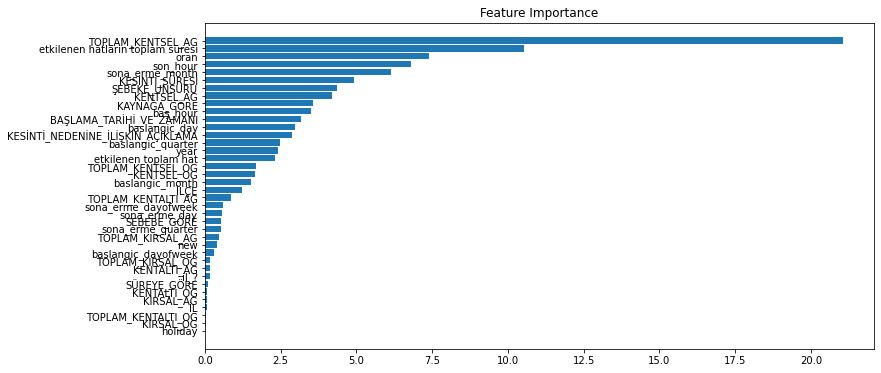

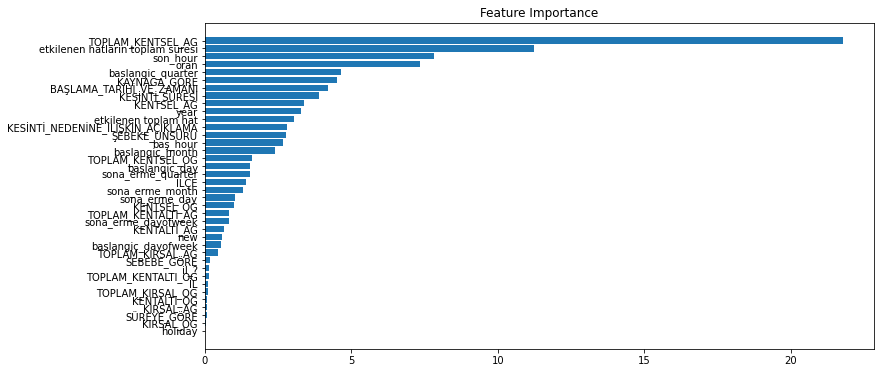

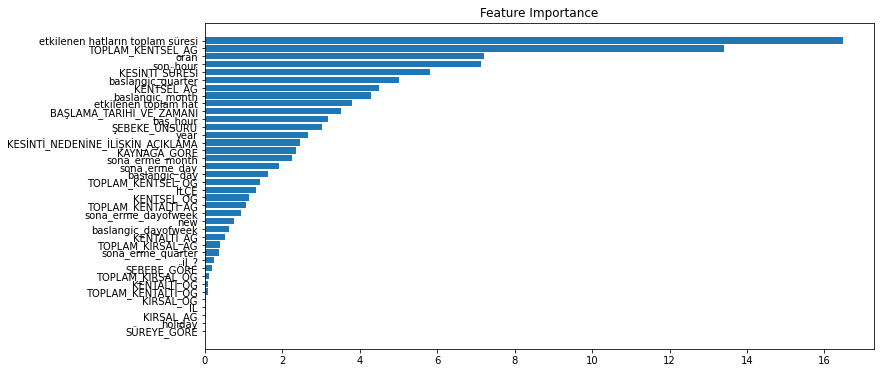

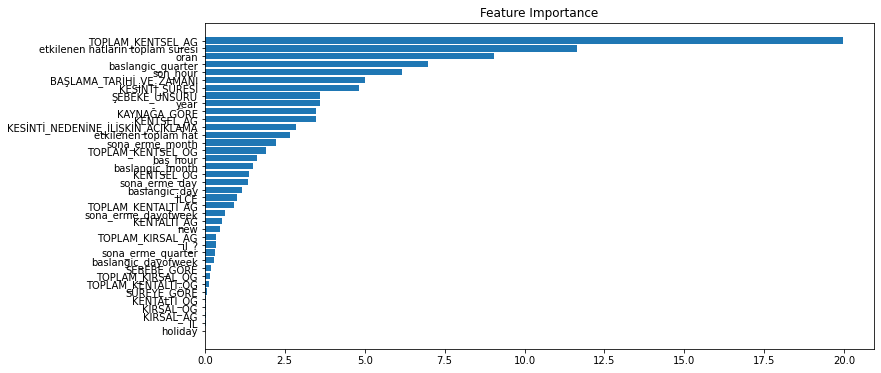

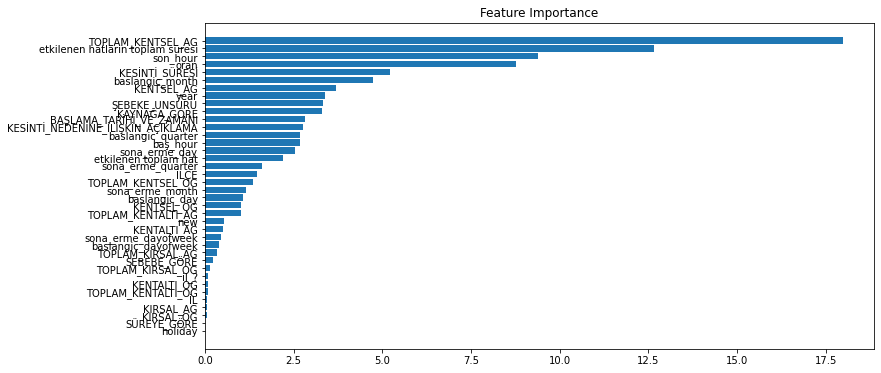

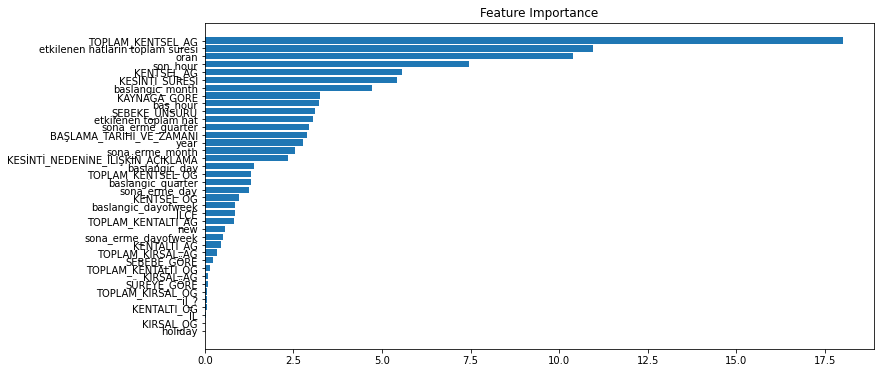

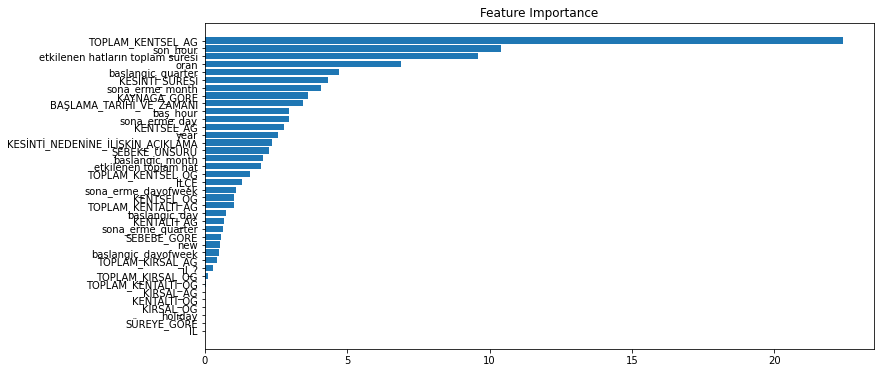

In [17]:
preds=pd.DataFrame(np.mean(unseen_preds,axis=0).round(),columns=['cagri_count'])

for i in range(0,len(importance)):
    feature_importance = importance[i]
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
    plt.title('Feature Importance')
    
submission=pd.concat([df[df.data=='test']['KESİNTİ_NO'].reset_index(drop=True),preds.reset_index(drop=True)],axis=1)
submission.cagri_count=submission.cagri_count.astype(int)

<AxesSubplot:>

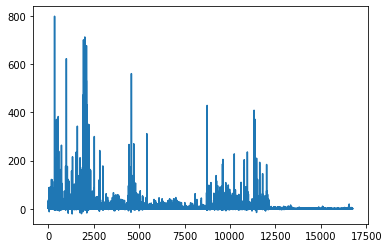

In [18]:
submission["cagri_count"].plot()

<AxesSubplot:>

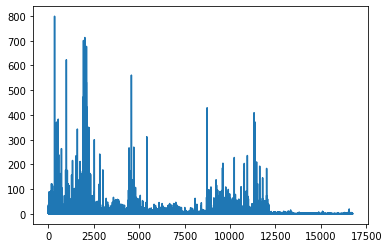

In [19]:
submission.loc[submission["cagri_count"]<0,"cagri_count"] =0
submission.cagri_count=submission.cagri_count.astype(int)
submission.to_csv(f"submission-{np.mean(score_list)}.csv",index=False)
submission["cagri_count"].plot()

In [20]:
assert False ,"Don't go there man!"

AssertionError: Don't go there man!

In [ ]:
lgbm_params = {'n_estimators': 100,'num_leaves': 14, 'max_depth': 8, 'learning_rate': 0.133462594683001, 'n_estimators': 132, 'min_child_weight': 0.40443820716736345}
enc = LabelEncoder()
for i in caterogical_cols:
    X[i] = enc.fit_transform(X[i])
    to_sub[i] = enc.transform(to_sub[i])

In [ ]:
random_state = 42
rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=random_state)
def RMSE(estimator, X_train, Y_train, cv=rkf,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

In [ ]:
lgbm = LGBMRegressor(**lgbm_params,random_state=random_state).fit(X,y)
score = RMSE(lgbm, X, y)
print("½) sCoRe:",score )

In [ ]:
unseen_preds = lgbm.predict(to_sub)
preds=pd.DataFrame(unseen_preds.round(),columns=['cagri_count'])
submission=pd.concat([df[df.data=='test']['KESİNTİ_NO'].reset_index(drop=True),preds.reset_index(drop=True)],axis=1)
submission.cagri_count=submission.cagri_count.astype(int)
submission["cagri_count"].plot()

In [ ]:
submission["cagri_count"]= submission["cagri_count"].apply(np.abs)
submission.to_csv(f"submission-{score}+1.csv",index=False)
submission["cagri_count"].plot()

In [ ]:
feat_imp = pd.Series(lgbm.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))